### Libraries

In [144]:
import geopandas as gpd
import pandas as pd
from timeit import timeit
from tkinter import NE
import pytest
import multiprocessing 
import numpy as np
from multiprocessing import Pool
import random
from functools import reduce
import time
from shapely.geometry import Point, Polygon
from sentinelhub import *
import os
import json
from functools import wraps
import pytest
import unittest
from unittest import mock
from unittest.mock import patch
from faker import Faker
import datetime as dt
import matplotlib.pyplot as plt
import re
import shutil, tempfile
from os import path
import unittest
import inspect
import matplotlib.pyplot as plt
from skopt.space import Space
from skopt.sampler import Sobol
from skopt.sampler import Lhs
from skopt.sampler import Halton
from skopt.sampler import Hammersly
from skopt.sampler import Grid
from scipy.spatial.distance import pdist
import dython

First, we read the dataframe that we would be using for sampling

In [145]:
gdf=gpd.read_file("/home/ahnaf.ryan/data_download/SaskGrid_2015_QUARTERSECTION/SaskGrid_2015_QUARTERSECTION.shp")

We are removing the rows with None values

In [146]:
gdf=gdf.head(-2)

Let us change this dataframe to work with only the columns that are important in this study 

In [147]:
gdf=gdf[["QSECT","PSECT","PTWP","PRGE","PMER"]]

In [148]:
gdf.head()

,QSECT,PSECT,PTWP,PRGE,PMER
0,NE,28,68,07,2
1,SE,35,68,07,2
2,NW,32,68,07,2
3,NE,12,68,07,2
4,SW,21,68,07,2


Let us first calculate the population attributes

### Sample Size Calculation

This dataframe contains the table that contains the variables required to estimate Sample Size for Multinomial Proportions (Thompson, Steven K. 1987. Sample size for estimating multinomial proportions. The American Statistician 41, no. 1: 42-46.)

In [149]:
def create_thompson_df():
    d={'alpha':[0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02,0.01,0.005,0.001,0.0005,0.0001]
    ,'d2n':[0.44129,0.50729,0.60123,0.74739,1.00635,1.27359,1.55963,1.65872,1.96986,2.28514,3.02892,3.33530,4.11209]
    ,'min_k':[4,4,3,3,3,3,2,2,2,2,2,2,2]}
    df=pd.DataFrame(d)
    return df

In [201]:
create_thompson_df()

,alpha,d2n,min_k
0,0.5000,0.44129,4
1,0.4000,0.50729,4
2,0.3000,0.60123,3
3,0.2000,0.74739,3
4,0.1000,1.00635,3
5,0.0500,1.27359,3
6,0.0250,1.55963,2
7,0.0200,1.65872,2
8,0.0100,1.96986,2
9,0.0050,2.28514,2


We use these variable to estimate our sample size and use it as a benchmark for our calculations.

In [150]:
def sample_size(df,d,alpha):
    thompson_df=create_thompson_df()
    d2n=thompson_df.loc[thompson_df['alpha']==alpha,'d2n'].iloc[0]
    n=d2n/d**2
    return round(n)
    
sample_size=sample_size(gdf,0.005,0.05)

### Population Attributes

In [151]:
def pop_attributes(df):
    qsect=df['QSECT'].value_counts(normalize=True) * 100
    pmer=df['PMER'].value_counts(normalize=True) * 100
    psect=df["PSECT"].value_counts(normalize=True)*100
    ptwp=df["PTWP"].value_counts(normalize=True)*100
    prge=df["PRGE"].value_counts(normalize=True)*100
    prge_pmer_comb=pd.Series((zip(df["PRGE"],df["PMER"])))
    prge_pmer=prge_pmer_comb.value_counts(normalize=True)*100
    return qsect,pmer,psect,ptwp,prge,prge_pmer
pop_at=pop_attributes(gdf)

Let us start by plotting some of the distribution of our attributes

In [152]:
def plot_bar(n,at,feature,type):
    at[n].plot.bar()
    plt.xlabel("Values")
    plt.ylabel("Percentage Count")
    plt.title("Normalized Percentage of " + feature + " for " + type)

We can see that the featurecd attribute has even distribution with almost ratio of 1:1. Now, let us see the distribution of qsect

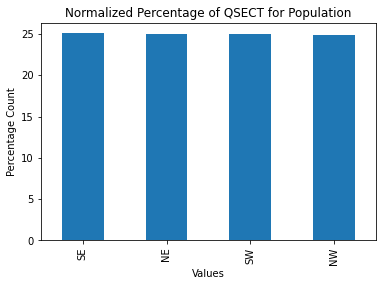

In [153]:
plot_bar(0,pop_at,"QSECT","Population")

Similar to featurecd, qsect values are evenly distributed. Now, let us look into the distribution of PMER

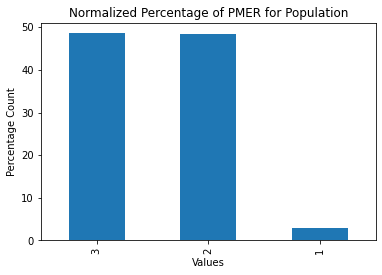

In [154]:
plot_bar(1,pop_at,"PMER","Population")

Here, we can see that 1 and 2 values are evenly distributed while 1 does not appear that much in the population

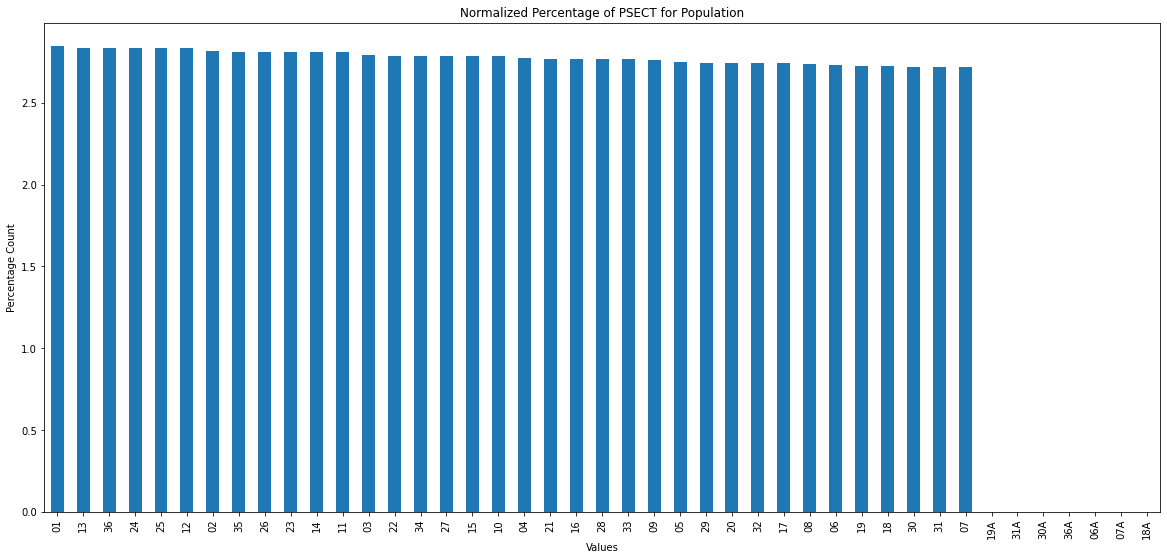

In [155]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(2,pop_at,"PSECT","Population")

PSECT distribution is an interesting observation with most values having even distribution but few values occur in negligible scale

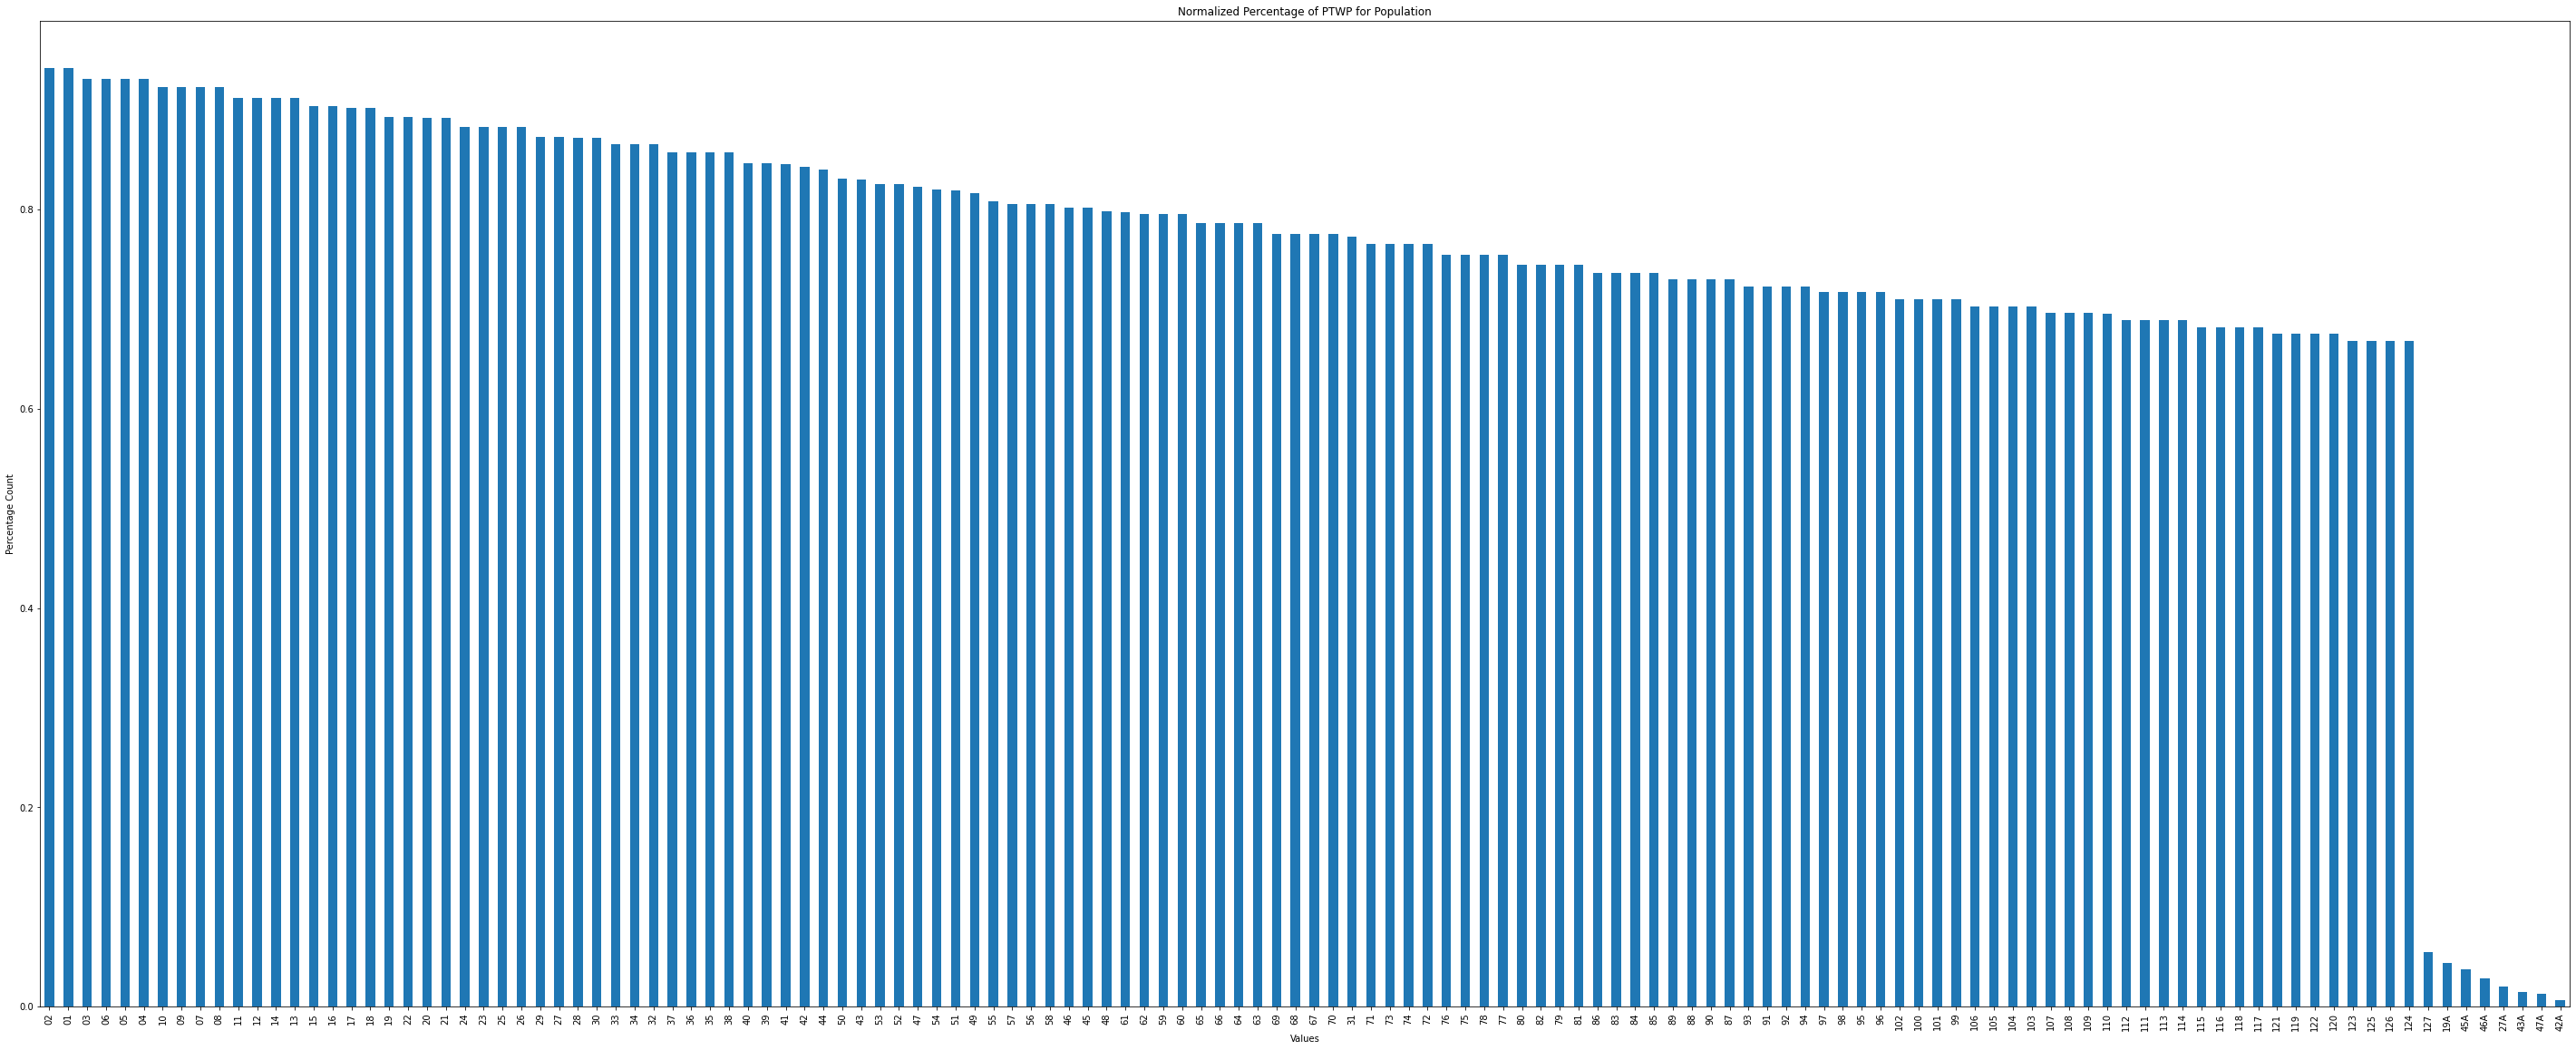

In [156]:
fig, ax = plt.subplots(figsize =(50, 20))
plot_bar(3,pop_at,"PTWP","Population")

The distribution of values slightly decreases as we go from left to right values in other words as values are increased, we see percentage to fall

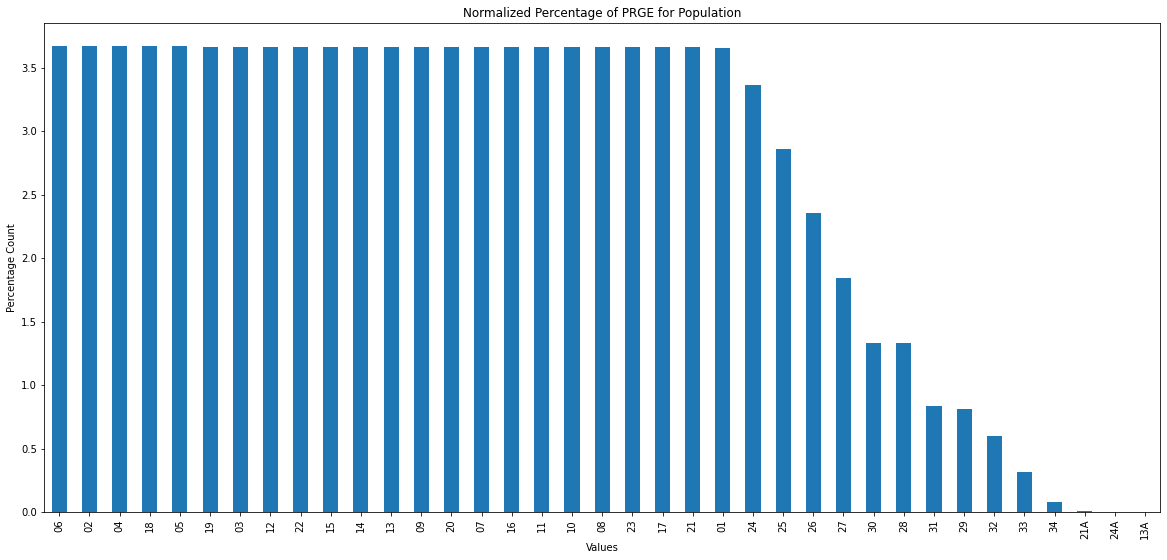

In [157]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(4,pop_at,"PRGE","Population")

PRGE has similar tendencies as PSECT

### Distribution of two categorical values together

Let us first try to understand if there is any association between two categorical variables and try to draw some insights from there.

<Figure size 1440x648 with 0 Axes>

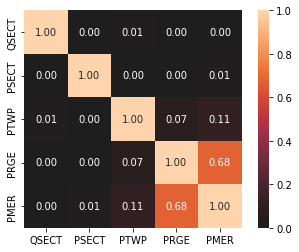

{'corr':           QSECT     PSECT      PTWP      PRGE      PMER
 QSECT  1.000000  0.000000  0.008250  0.000000  0.000898
 PSECT  0.000000  1.000000  0.004841  0.004950  0.011495
 PTWP   0.008250  0.004841  1.000000  0.068555  0.113564
 PRGE   0.000000  0.004950  0.068555  1.000000  0.679638
 PMER   0.000898  0.011495  0.113564  0.679638  1.000000,
 'ax': <AxesSubplot:>}

In [158]:
from matplotlib.pyplot import figure
figure(figsize =(20, 9))
from dython.nominal import associations
associations(gdf)

Interestingly, there is a strong association between PRGE and PMER. So let us explore the distribution of their combined values of PRGE and PMER

<AxesSubplot:xlabel='PRGE', ylabel='PMER'>

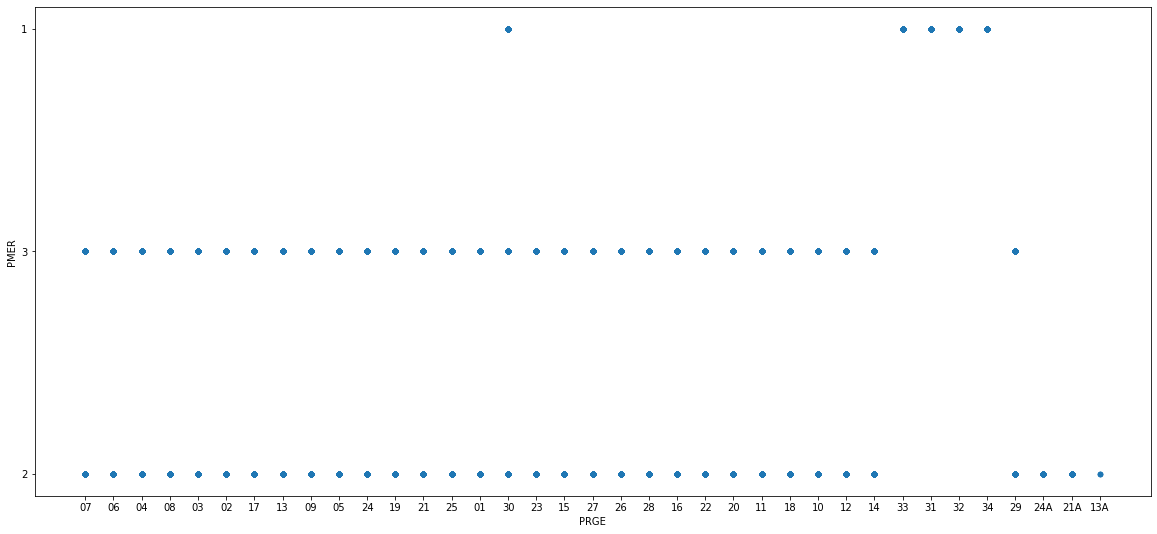

In [159]:
gdf.plot.scatter(y="PMER",x="PRGE",figsize=(20,9))

Due to strong association, it means that with values of PRGE we can easily predict PMER values for example if PRGE is between 31 to 34, we can say it will be 1.

Based on the scatterplot, we can see value 2 and 3 are spread across the values of PRGE however distribution of 1 is between 31 to 34.

Text(0.5, 1.0, 'Normalized Percentage of (PMER,PRGE) for Population')

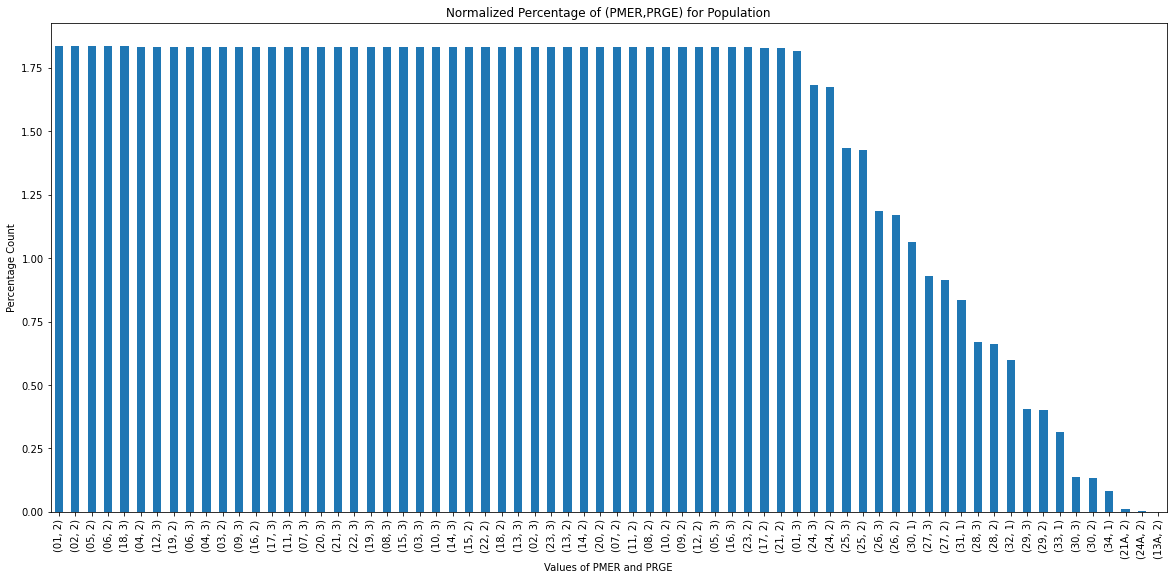

In [160]:
fig, ax = plt.subplots(figsize =(20, 9))
pop_at[5].plot.bar()
plt.xlabel("Values of PMER and PRGE")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of (PMER,PRGE) for Population")

We can see that relatively for most values, there is a constant percentage of values together however for higher values, the distribution of percentage values is decreasing.

We expect the distribution of these variables in our sample similarly.

Let us look at scatter plot of all the variables

In [161]:
##import plotly.express as px 
#fig=px.scatter_matrix(gdf,width=800,height=400)
#fig.show()

### Different Types of Sampling Techniques

Ideally, we would like our sample to follow similar distribution so we start by trying different sampling techniques

We first start with random sampling with replacement

#### 1) Random Sampling without Replacement

In [162]:
def random_sampling_rep(gdf):
    return gdf.sample(n=sample_size,replace=False)
samp_nrep_at=pop_attributes(random_sampling_rep(gdf))

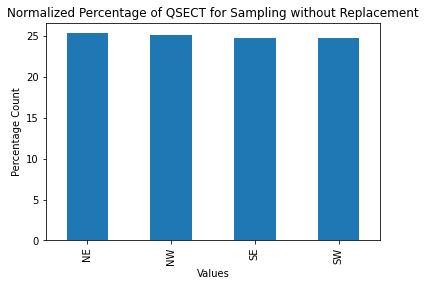

In [163]:
plot_bar(0,samp_nrep_at,"QSECT","Sampling without Replacement")

Random Sampling without replacement did a good job in sampling featurecd values since it looks similar to the population.

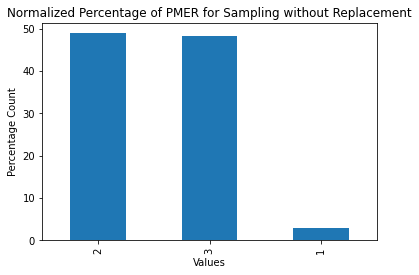

In [164]:
plot_bar(1,samp_nrep_at,"PMER","Sampling without Replacement")

Again, it looks very similar to the population. We now repeat for the other attributes and try to quantify the absolute error

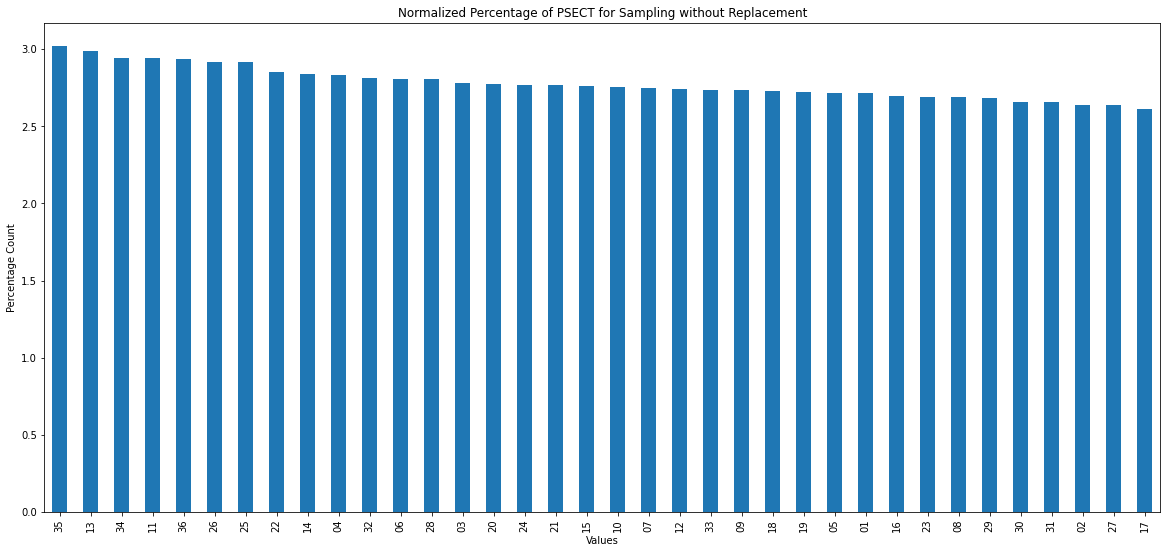

In [165]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(2,samp_nrep_at,"PSECT","Sampling without Replacement")

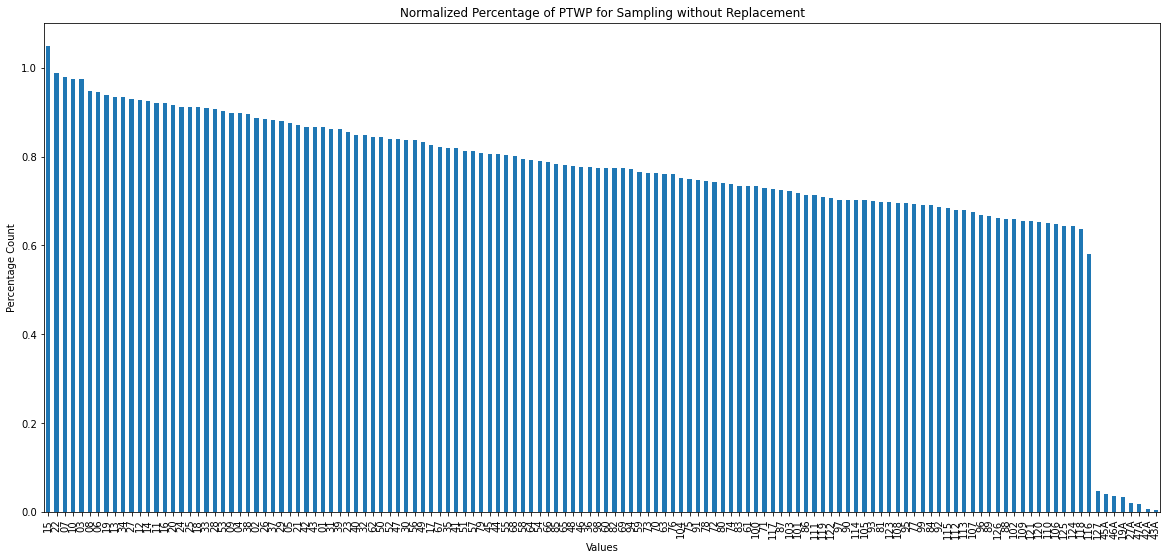

In [166]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(3,samp_nrep_at,"PTWP","Sampling without Replacement")

It does a decent job in understanding the distribution of PSECT

Our sample do not capture the outliers at all from the population for PSECT which is expected

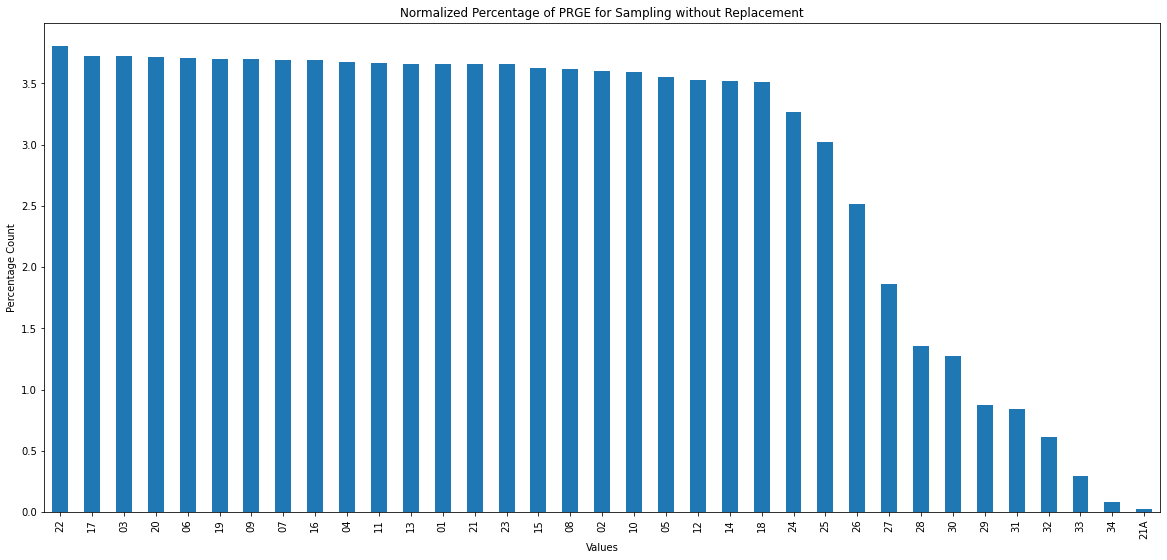

In [167]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(4,samp_nrep_at,"PRGE","Sampling without Replacement")

This is astonshingly similar to the population

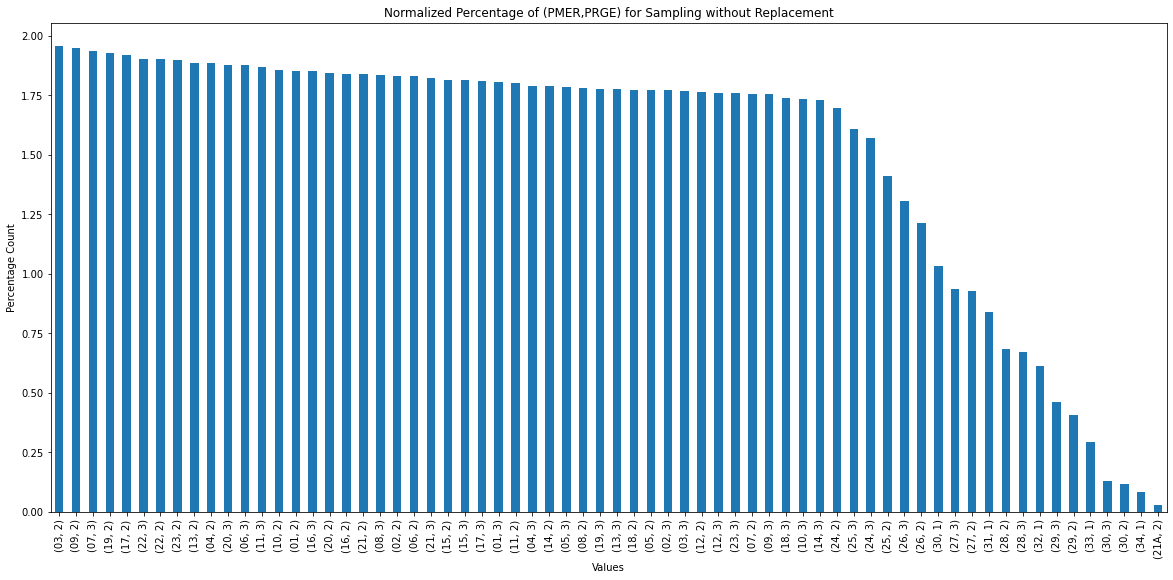

In [168]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(5,samp_nrep_at,"(PMER,PRGE)","Sampling without Replacement")

PRGE is also quite good in this sampling technique

Let us calculate the sample errors for Random Sampling without Replacement

In [169]:
def samp_error(pop_at,samp_at):
    samp_qsect_error=np.sum(abs(pop_at[0]-samp_at[0]))
    samp_pmer_error=np.sum(abs(pop_at[1]-samp_at[1]))
    samp_psect_error=np.sum(abs(pop_at[2]-samp_at[2]))
    samp_ptwp_error=np.sum(abs(pop_at[3]-samp_at[3]))
    samp_prge_error=np.sum(abs(pop_at[4]-samp_at[4]))
    samp_prge_pmer_error=np.sum(abs(pop_at[5]-samp_at[5]))
    return samp_qsect_error,samp_pmer_error,samp_psect_error,samp_ptwp_error,samp_prge_error,samp_prge_pmer_error
    

In [170]:
error_samp_nrep=samp_error(pop_at,samp_nrep_at)

These are absolute sample errors for our attributes for Random Sampling without replacement. Now let us move to random sampling with replacement

#### Sampling with Replacement

In [171]:
def random_sampling_rep(gdf):
    return gdf.sample(n=sample_size,replace=True)
samp_rep_at=pop_attributes(random_sampling_rep(gdf))

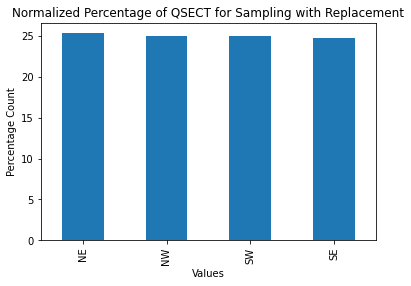

In [172]:
plot_bar(0,samp_rep_at,"QSECT","Sampling with Replacement")

Sampling with Replacement also does a good job in sampling Featurecd values but not as good as sampling without replacement

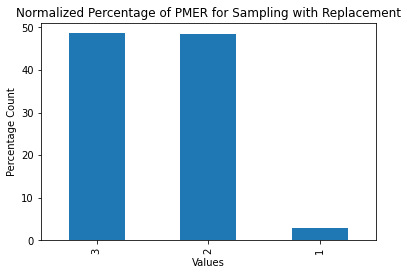

In [173]:
plot_bar(1,samp_rep_at,"PMER","Sampling with Replacement")

It does a good job in QSECT as it is similar to the population

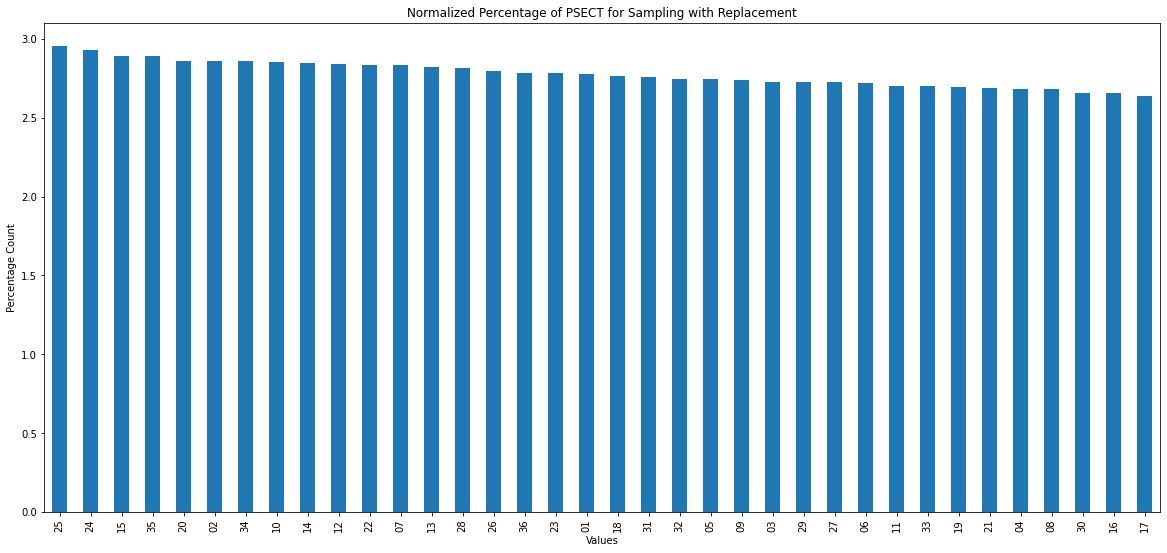

In [174]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(2,samp_rep_at,"PSECT","Sampling with Replacement")

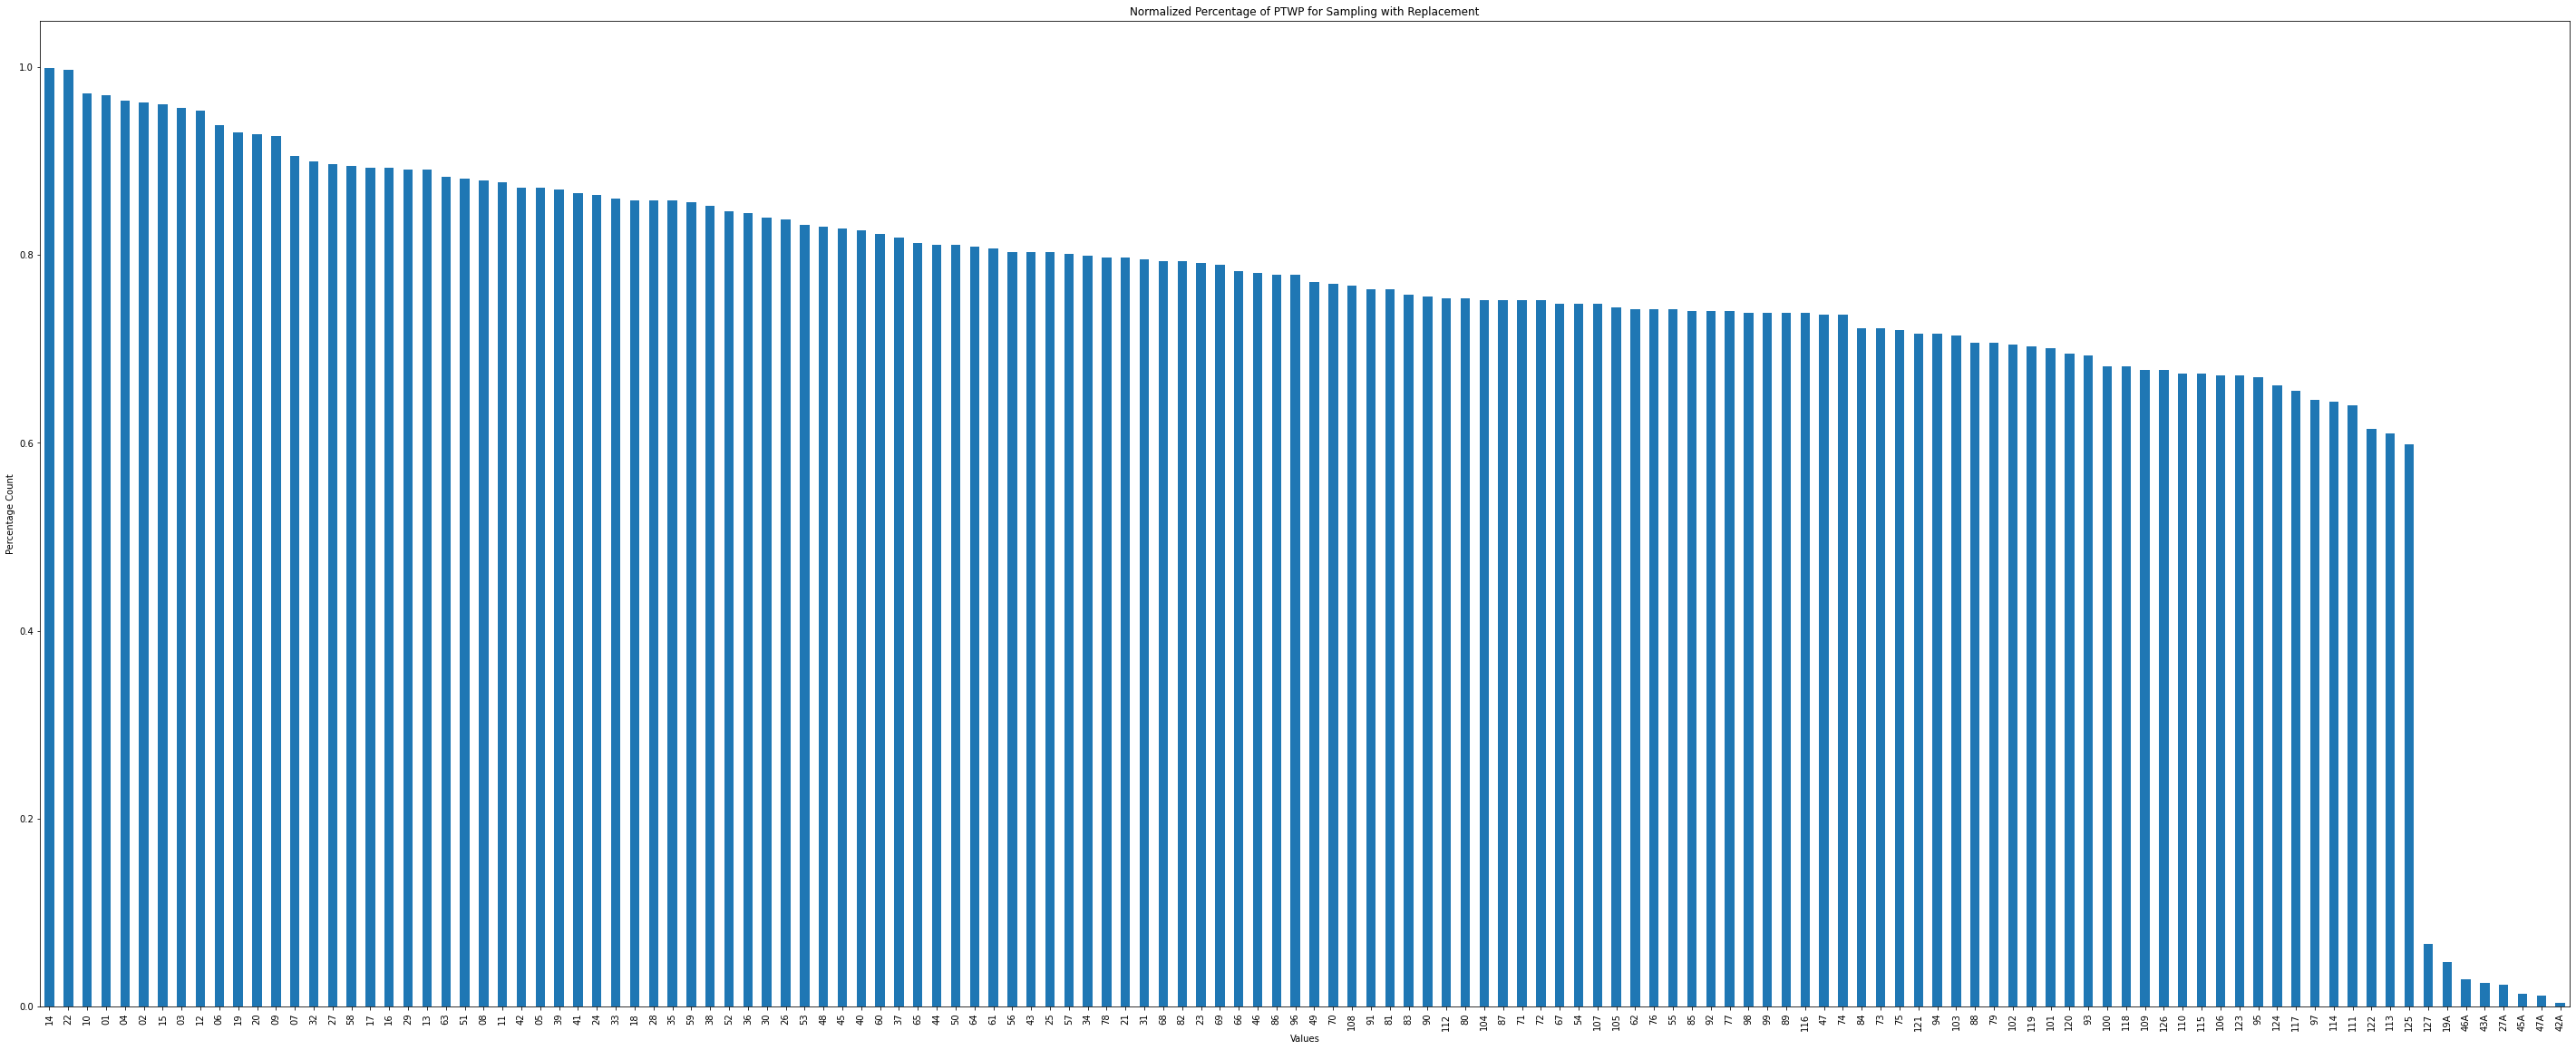

In [175]:
fig, ax = plt.subplots(figsize =(50, 20))
plot_bar(3,samp_rep_at,"PTWP","Sampling with Replacement")

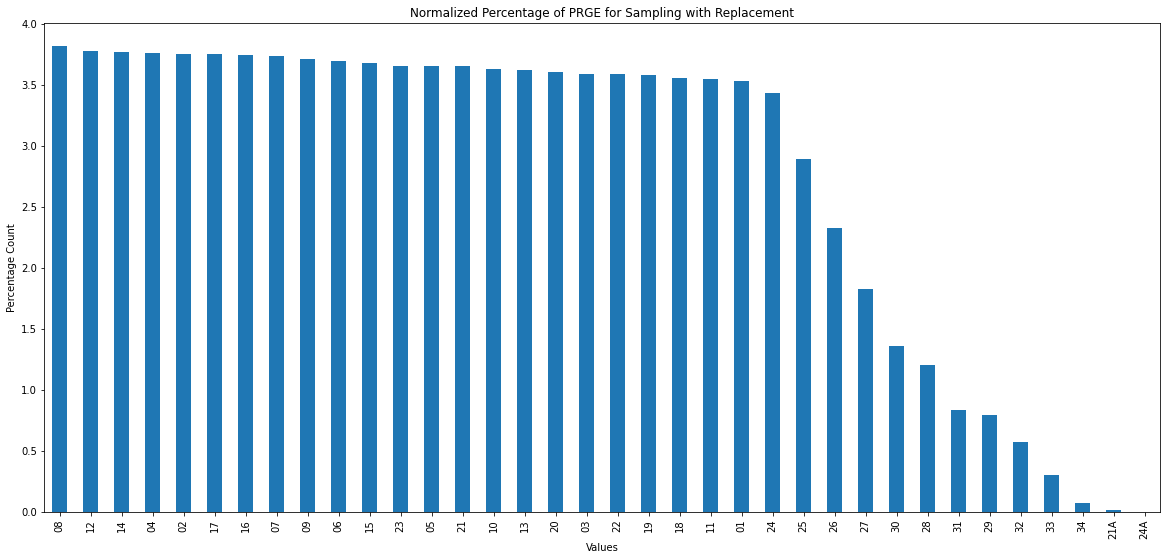

In [176]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(4,samp_rep_at,"PRGE","Sampling with Replacement")

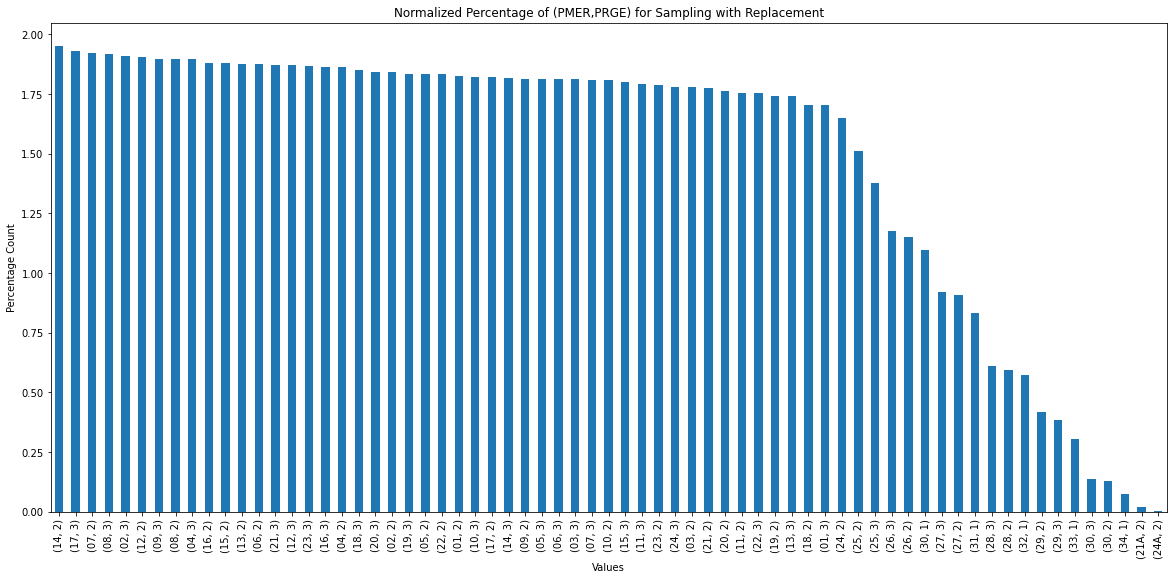

In [177]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(5,samp_rep_at,"(PMER,PRGE)","Sampling with Replacement")

Overall, we can see that sampling with replacement did a good job but not as good as sampling without replacement

In [178]:
error_samp_rep=samp_error(pop_at,samp_rep_at)

These are the absolute sample errors for sampling with Replacement. Let us move to stratified sampling now.

#### Sampling with Stratification

In [179]:
def stratified_sampling(gdf,col):
    grouped_df=gdf.groupby(col)
    df=gdf.head(0)
    for key,item in grouped_df:
        a_group=grouped_df.get_group(key)
        ratio=len(a_group)/len(gdf)
        samp=a_group.sample(n=round(ratio*sample_size))
        df=pd.concat([df,samp])
    return df    
samp_st_at=pop_attributes(stratified_sampling(gdf,gdf.PRGE))

Sampling with strafication does a great job in featurecd

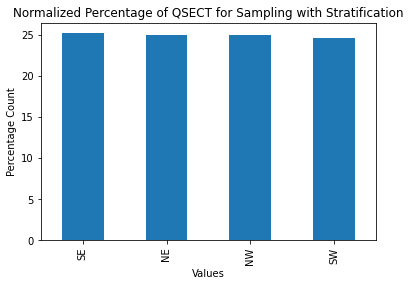

In [180]:
plot_bar(0,samp_st_at,"QSECT","Sampling with Stratification")

As expected, it does an excellent job since stratification was done on QSECT

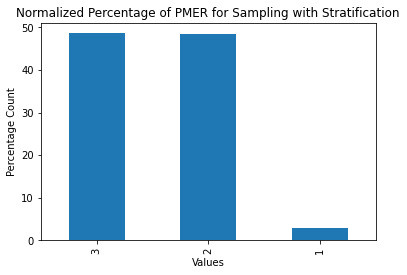

In [181]:
plot_bar(1,samp_st_at,"PMER","Sampling with Stratification")

It does a great job on PMER

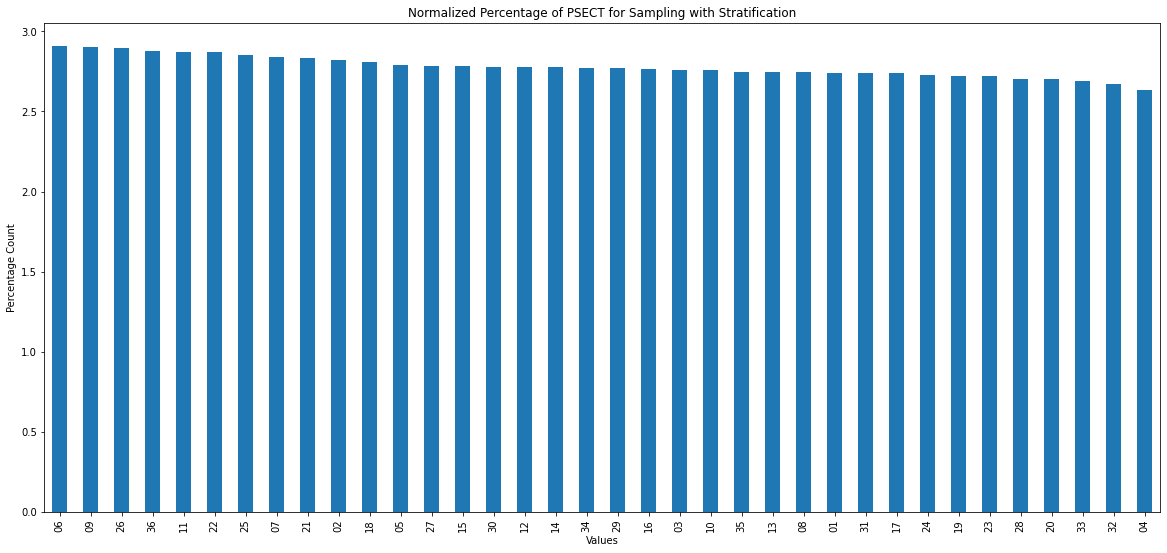

In [182]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(2,samp_st_at,"PSECT","Sampling with Stratification")

Stratification does not do a good job for PSECT since we can see 01 values appear the least when they appear the most

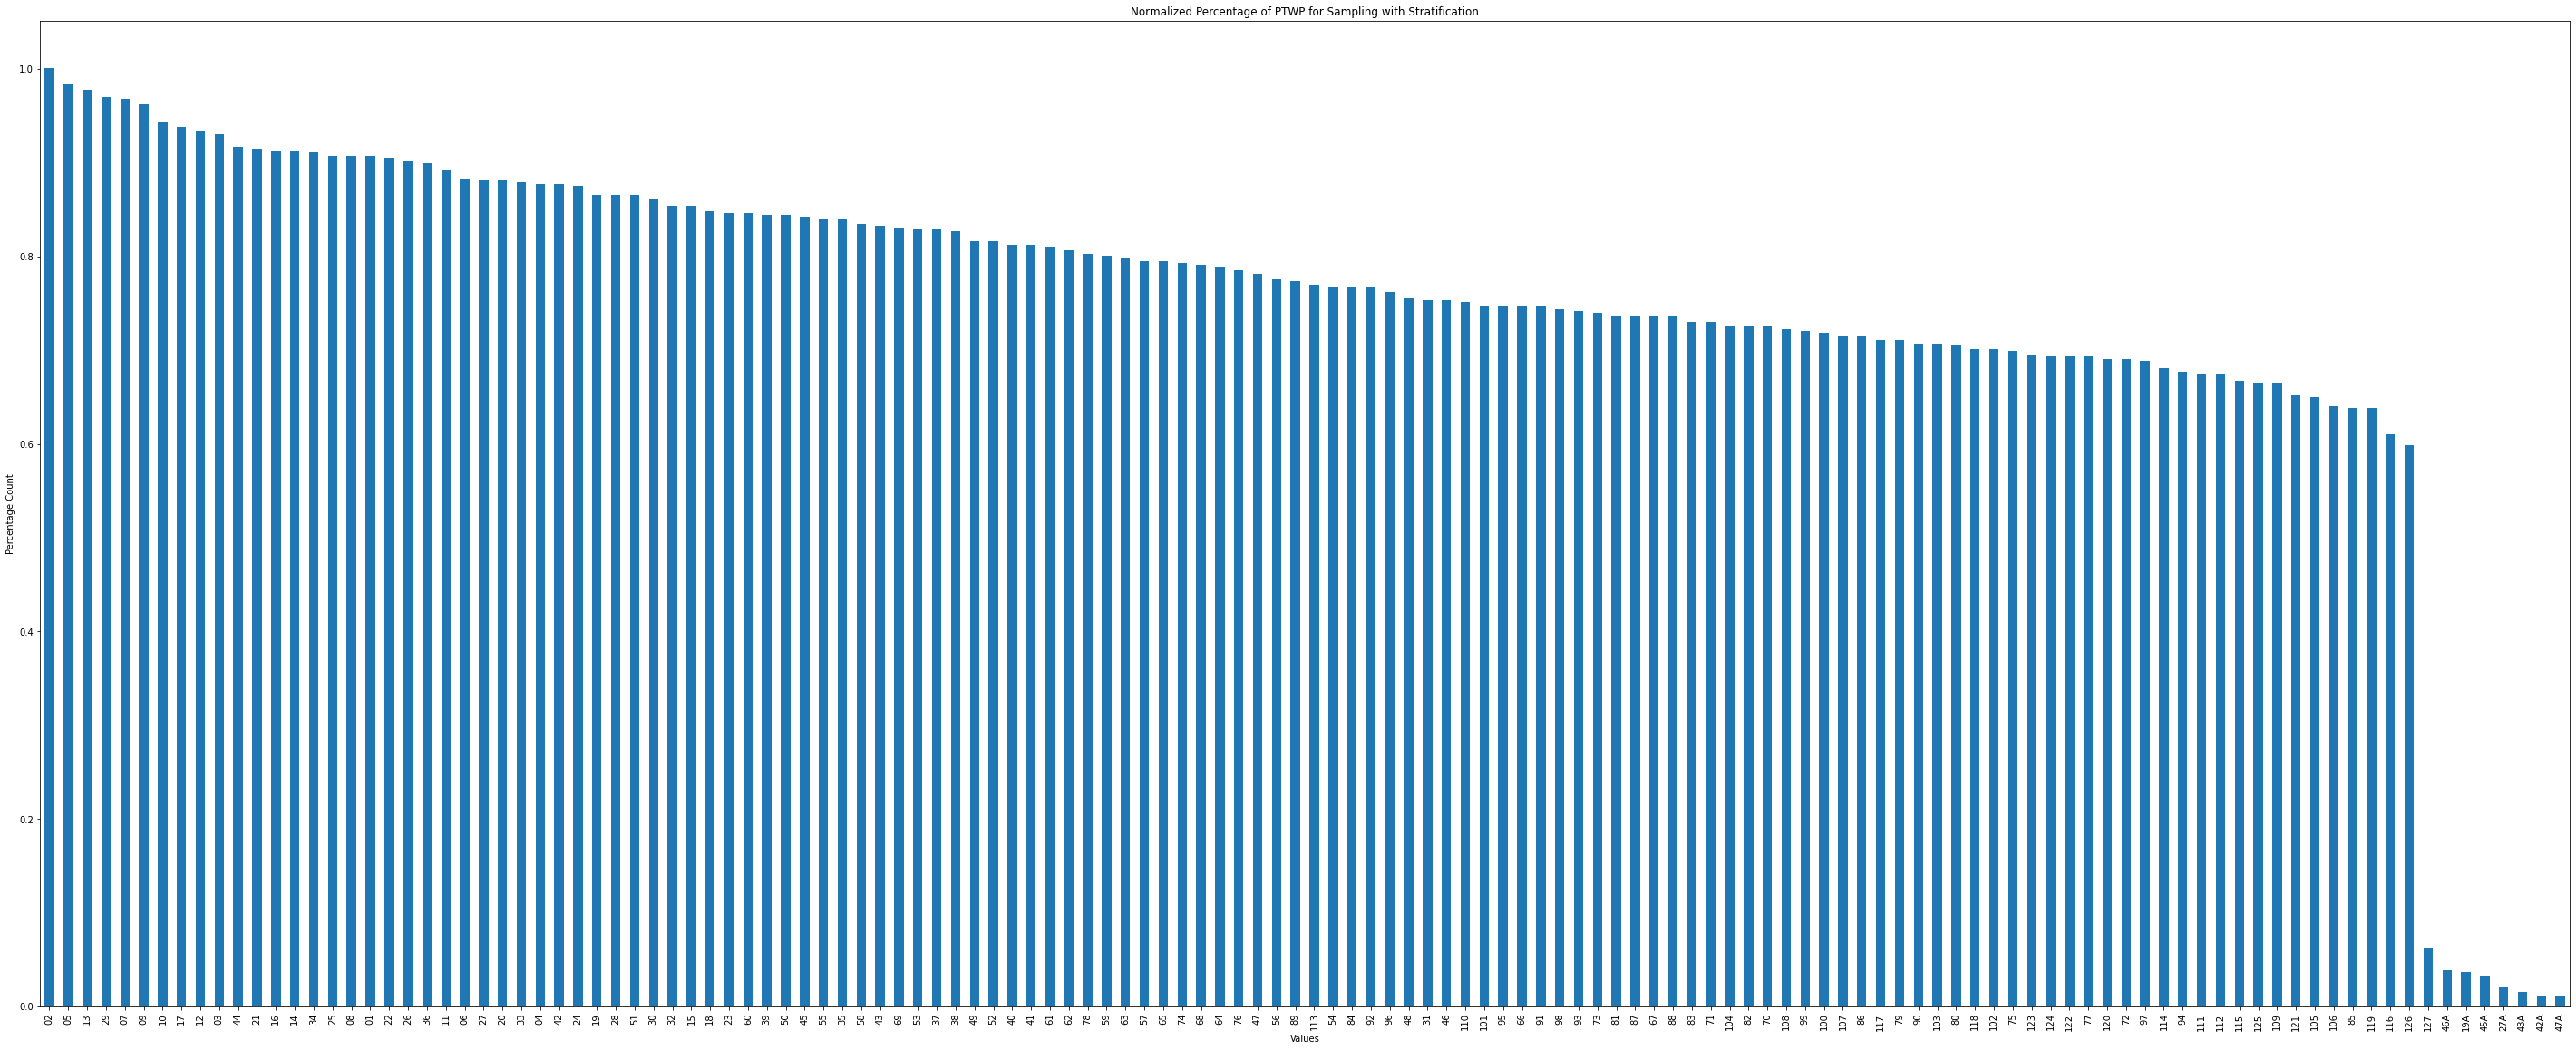

In [183]:
fig, ax = plt.subplots(figsize =(50, 20))
plot_bar(3,samp_st_at,"PTWP","Sampling with Stratification")

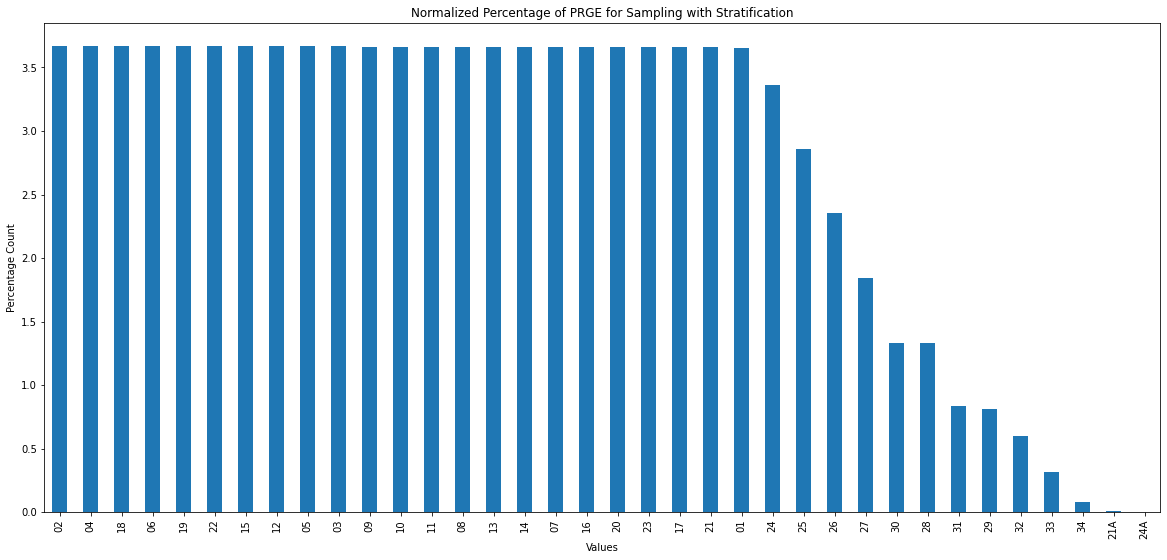

In [184]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(4,samp_st_at,"PRGE","Sampling with Stratification")

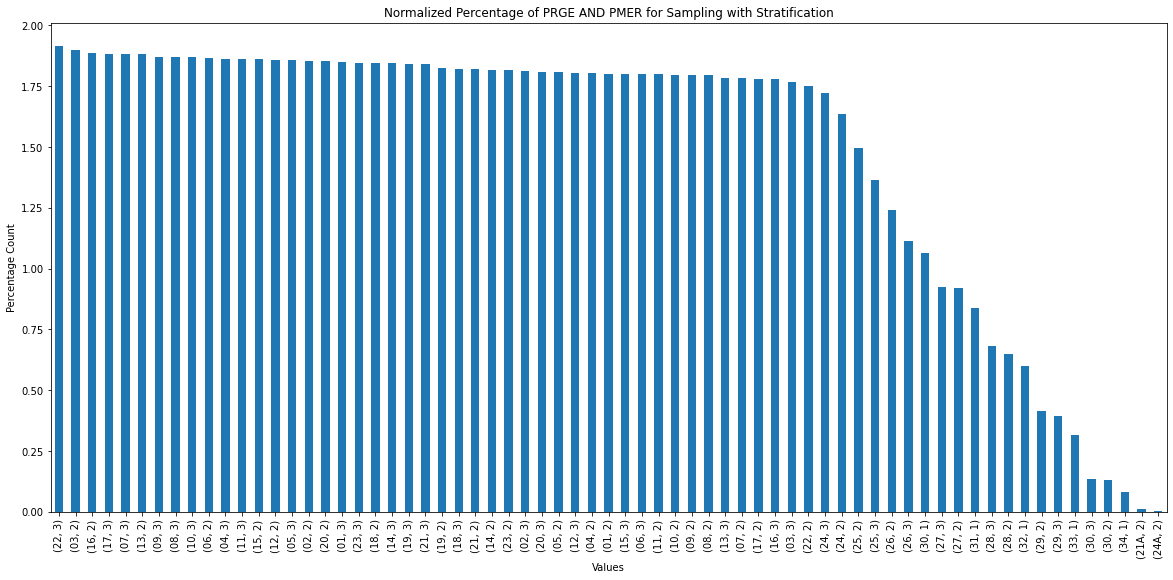

In [185]:
fig, ax = plt.subplots(figsize =(20, 9))
plot_bar(5,samp_st_at,"PRGE AND PMER","Sampling with Stratification")

it does a good job for PRGE

In [186]:
samp_error_str=samp_error(pop_at,samp_st_at)

These are the absolute sample errors stratified sampling.Now, let us move to a different sampling technique where we divide the dataframe into

In [187]:
gdf.head()

,QSECT,PSECT,PTWP,PRGE,PMER
0,NE,28,68,07,2
1,SE,35,68,07,2
2,NW,32,68,07,2
3,NE,12,68,07,2
4,SW,21,68,07,2


In [188]:
gdf["prge_pmer_psect"]=list(zip(gdf["PRGE"],gdf["PMER"]))
gdf.head()

,QSECT,PSECT,PTWP,PRGE,PMER,prge_pmer_psect
0,NE,28,68,07,2,"(07, 2)"
1,SE,35,68,07,2,"(07, 2)"
2,NW,32,68,07,2,"(07, 2)"
3,NE,12,68,07,2,"(07, 2)"
4,SW,21,68,07,2,"(07, 2)"


In [189]:
samp_error_str=samp_error(pop_at,samp_st_at)

#### Sampling with Custom Stratification/ Orthogonality

In [190]:
def orthogonal_sampling(gdf):
    split=np.array_split(gdf,sample_size)
    df=gdf.head(0)
    for values in split:
        x=values.sample(n=1)
        df=pd.concat([df,x])
    return df

In [191]:
samp_or_at=pop_attributes(orthogonal_sampling(gdf))

It does a excellent job as distribution is similar to population

Text(0.5, 1.0, 'Normalized Percentage of QSECT')

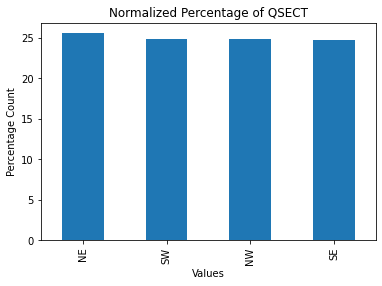

In [192]:
samp_or_at[0].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of QSECT")


it does a good job overally but relatively it is the worst out of the other techniques

Text(0.5, 1.0, 'Normalized Percentage of PMER')

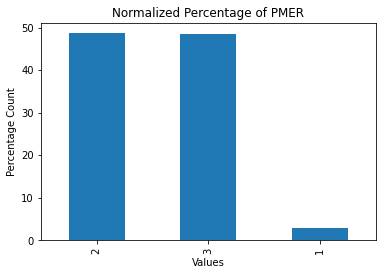

In [193]:
samp_or_at[1].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PMER")

It does a good job since the distribution is similar to population

Text(0.5, 1.0, 'Normalized Percentage of PSECT')

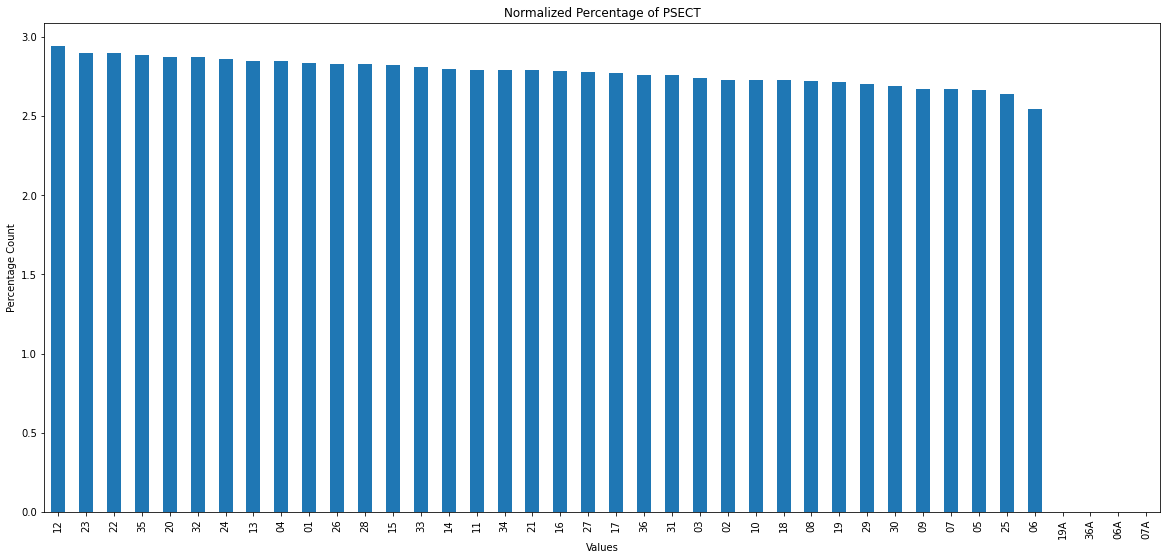

In [194]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_or_at[2].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PSECT")

It does a similar job compared to the sampling techniques for PSECT

Text(0.5, 1.0, 'Normalized Percentage of PTWP')

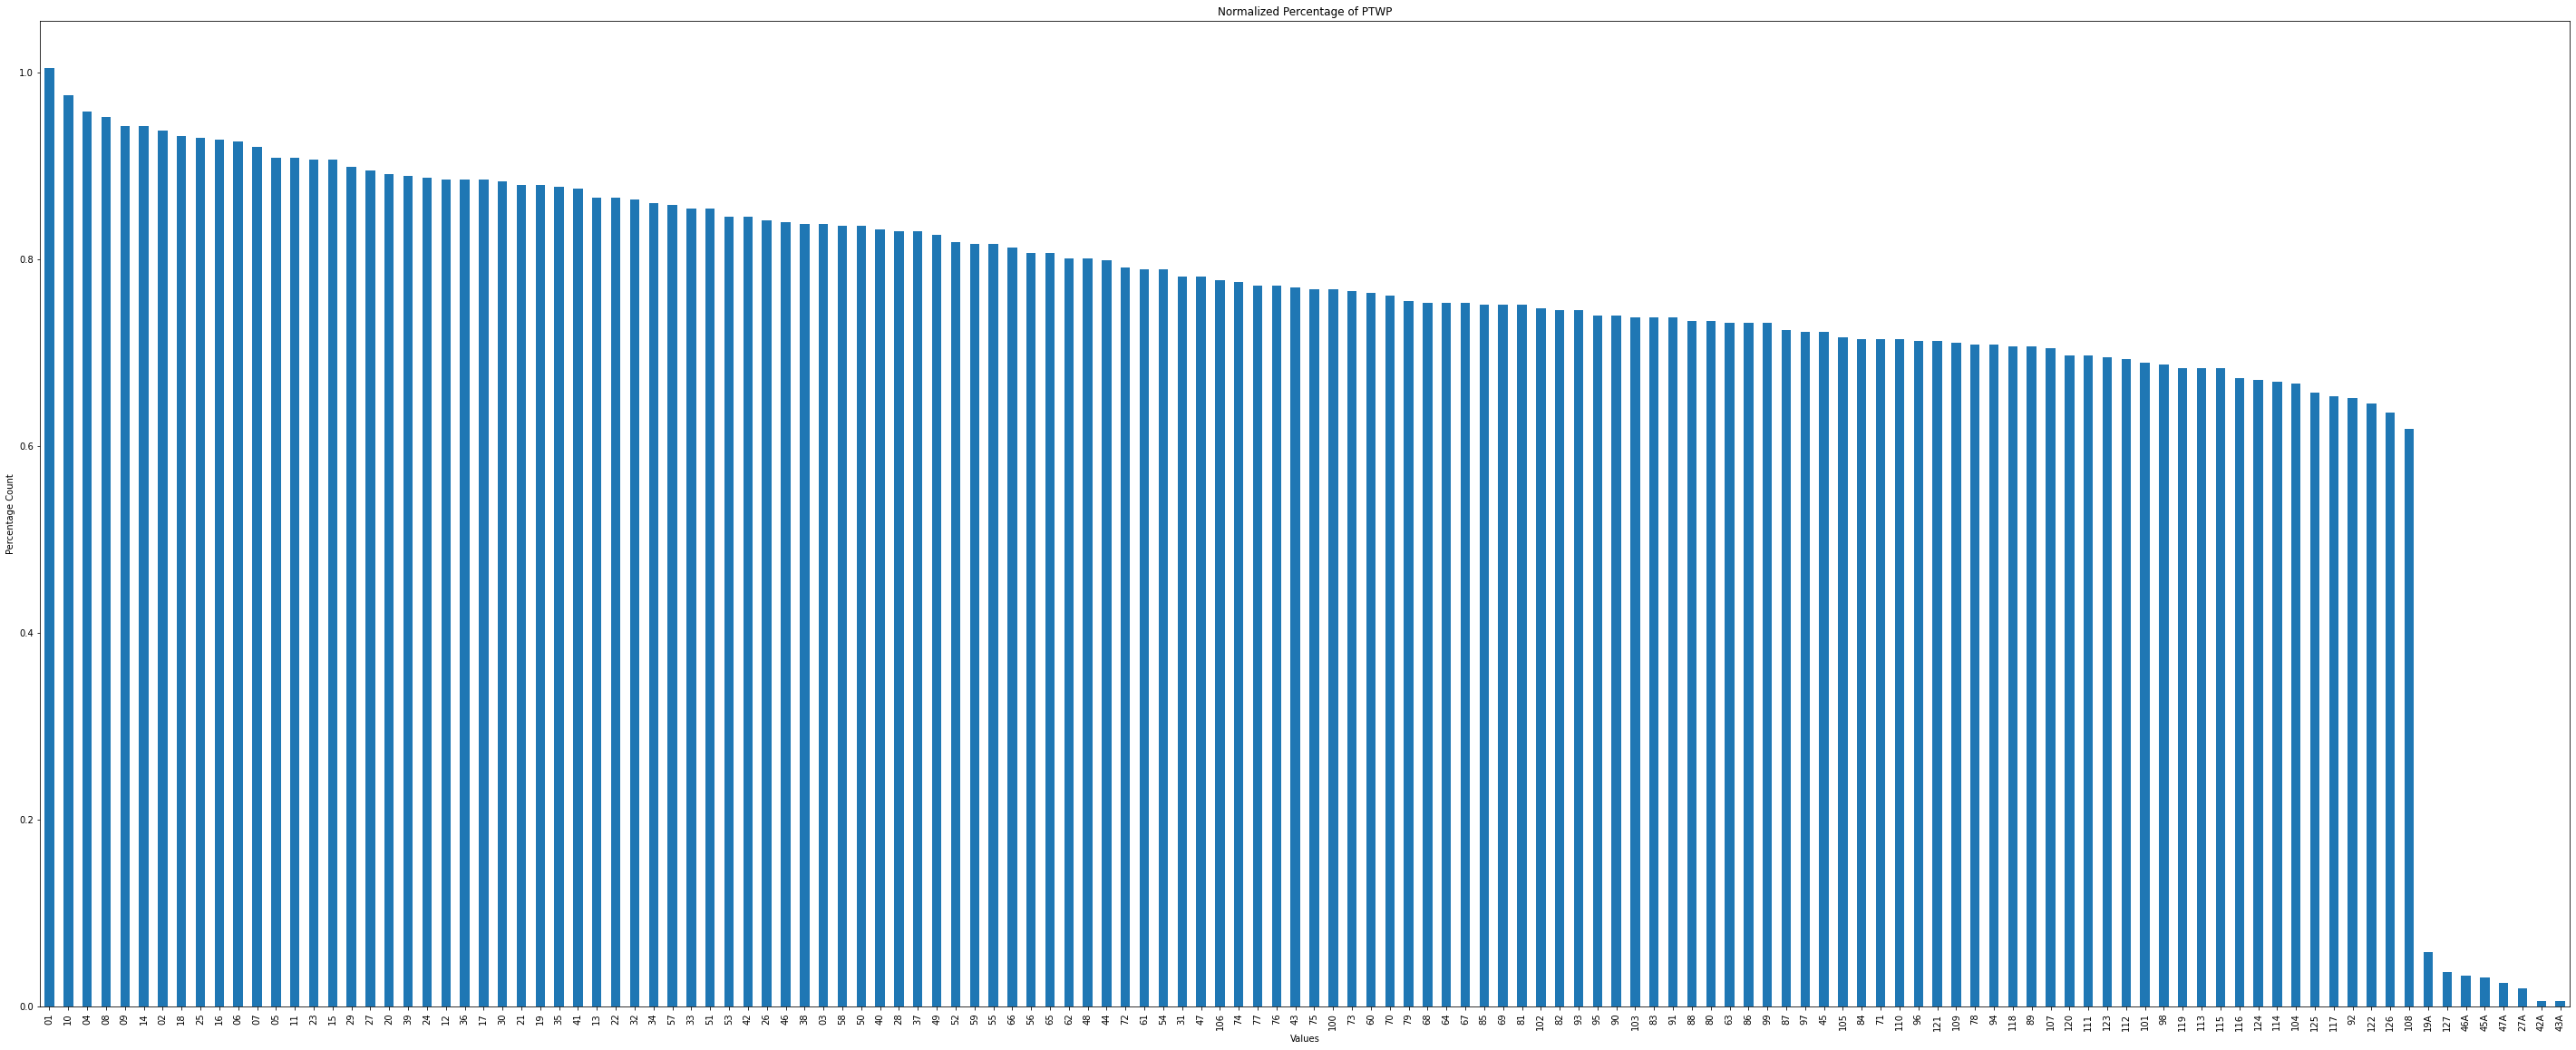

In [195]:
fig, ax = plt.subplots(figsize =(50, 20))
samp_or_at[3].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PTWP")

It does an excellent job since the distribution looks identical to the population

Text(0.5, 1.0, 'Normalized Percentage of PRGE')

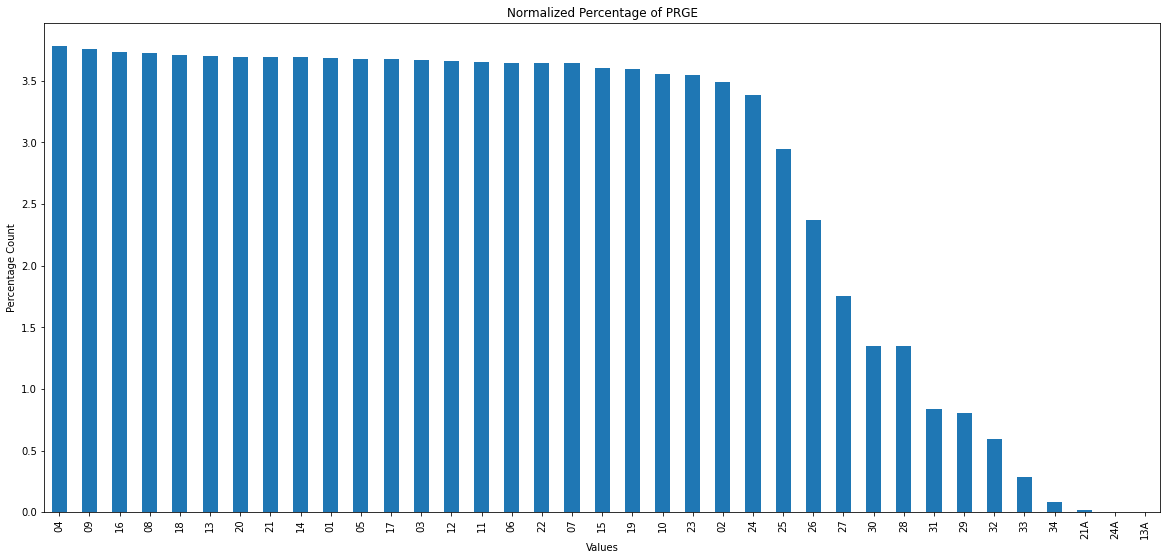

In [196]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_or_at[4].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE")

Text(0.5, 1.0, 'Normalized Percentage of PRGE For Custom Stratification')

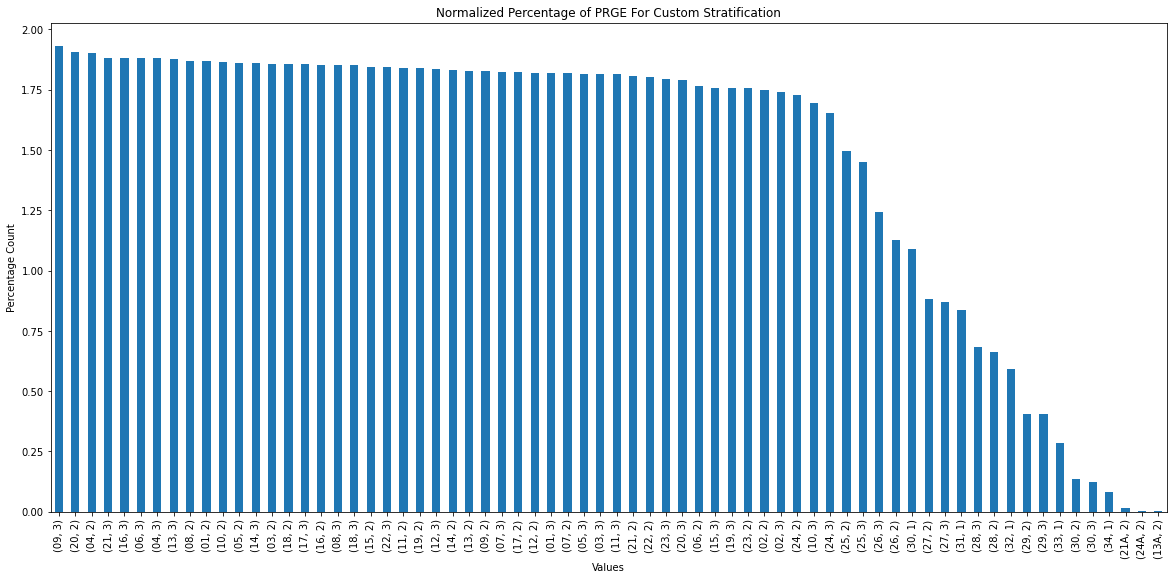

In [197]:
fig, ax = plt.subplots(figsize =(20, 9))
samp_or_at[5].plot.bar()
plt.xlabel("Values")
plt.ylabel("Percentage Count")
plt.title("Normalized Percentage of PRGE For Custom Stratification")

In [198]:
error_samp_ort=samp_error(pop_at,samp_or_at)

Let us draw bar graphs to see which one did best

[1.07294557581206, 0.8089929962201268, 2.6911231313783235, 3.9397693953803383, 1.91679884591027, 3.0980909348438224]


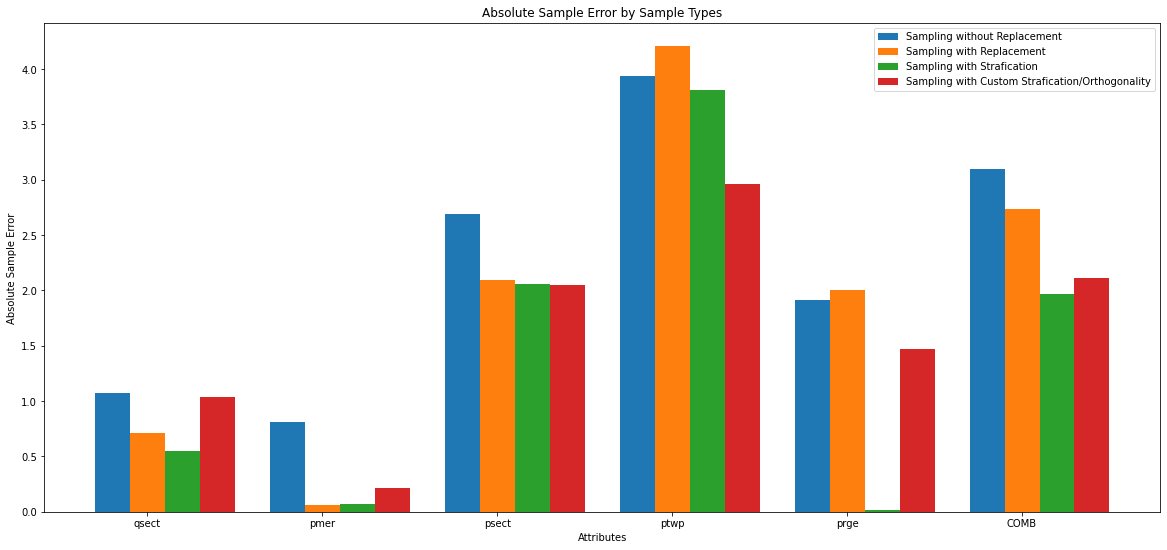

In [200]:
fig, ax = plt.subplots(figsize =(20, 9))
x_val=["qsect","pmer","psect","ptwp","prge","COMB"]
list_error_samp_nrep=list(error_samp_nrep)
print(list_error_samp_nrep)
list_error_samp_rep=list(error_samp_rep)
list_error_samp_str=list(samp_error_str)
list_error_samp_ort=list(error_samp_ort)
X_axis=np.arange(len(x_val))
width=0.2
plt.bar(X_axis,list_error_samp_nrep,width,label="Sampling without Replacement")
plt.bar(X_axis+width,list_error_samp_rep,width,label="Sampling with Replacement")
plt.bar(X_axis+width*2,list_error_samp_str,width,label="Sampling with Strafication")
plt.bar(X_axis+width*3,list_error_samp_ort,width,label="Sampling with Custom Strafication/Orthogonality")


plt.xticks(X_axis+width,x_val)
plt.xlabel("Attributes")
plt.ylabel("Absolute Sample Error")
plt.title("Absolute Sample Error by Sample Types")
plt.legend()
plt.show()

Based on the plot, we can conclude that sampling with stratification performed best